# 4DVar with the Lorenz 63 system

* Emmanuel Cosme, 2022

This notebook illustrates the implementation of the 4DVar data assimilation method with the 3-variable, chaotic Lorenz 63 system (https://en.wikipedia.org/wiki/Lorenz_system). This dynamical model is often used to test data assimilation methods, because it displays a chaotic behavior, as the atmosphere and the ocean do, with very low dimensionality.

### To-do list:

* cycle multiple assimilation windows
* go beyond the too simple Euler scheme
* implement with JAX


## Definition of Lorenz model
The Lorenz system is:
$$ \dot{x} = \sigma (y-x) $$
$$ \dot{y} = x (\rho -z ) -y $$
$$ \dot{z} = xy -\beta z $$
In the cell below, it is coded in a class with default parameters $\sigma = 10$, $\rho = 28$, $\beta=8/3$.

The class also implements the tangent linear model and the adjoint model.

In [1]:
import numpy as onp
import matplotlib.pyplot as plt
%matplotlib inline
import jax.scipy.optimize as so

import jax.numpy as np
from jax import grad, jit, vmap
from jax import random

In [124]:
#-------------------------------------------------------
# Lorenz 63 model
#-------------------------------------------------------

class Model:

    def __init__( self ):
        self.nx = 3                         # number of variables (Lorenz 63)
        self.sigma = 10.
        self.rho = 28.
        self.beta = 8./3.
        self.dt = 0.01
        self.xvar = np.zeros(3)
        self.xvar_series = []
        self.time = 0.
        self.time_series = []
        
    def rhs(self,x_in):
        """right hand side term of Lorenz 63"""
        a = self.sigma*(x_in[1] - x_in[0])
        b = self.rho*x_in[0] - x_in[1] - x_in[0]*x_in[2]
        c = x_in[0]*x_in[1] - self.beta*x_in[2]
        return np.array([a,b,c])
    
    def forward(self, x_in, nstep_in):
        """Perform time stepping of the model. Times and data are saved in arrays time_series and xvar_series.
        Input: x_in, initial value; number of steps."""
        self.xvar = 1.*x_in
        self.xvar_series = np.zeros((self.nx, nstep_in))
        self.time_series = np.zeros(nstep_in)
        for it in range(nstep_in):
            #self.xvar_series[:,it] = self.xvar
            #self.time_series[it] = self.time
            self.xvar_series = self.xvar_series.at[:,it].set(self.xvar)
            self.time_series = self.time_series.at[it].set(self.time)
            ## Euler
            self.xvar += self.rhs(self.xvar)*self.dt
            self.time += self.dt
              
    def plot(self):
        plt.figure(figsize=(12,8))
        for ix in range(self.nx):
            pnum = 311+ix
            plt.subplot(pnum)
            plt.plot(self.time_series[:],self.xvar_series[ix,:],'black',linewidth=1.)
        plt.show()

## Presentation of the Lorenz system
Below is a trajectory of the Lorenz system is represented in the phase space (3D, and X-Z plan below). The "butterfly" clearly shows two attractors. The system state can switch from one lob to the other when It is extremely difficult to predict.

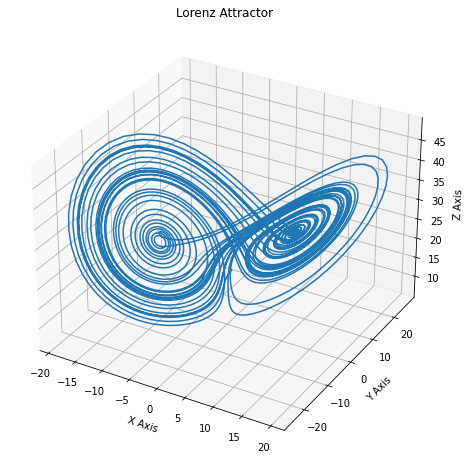

In [125]:
lorenz_test = Model()
xtrue = np.array([1.5, -1.5, 20.])
lorenz_test.forward(xtrue, 5000)

ax = plt.figure(figsize=(8,8)).add_subplot(projection='3d')
ax.plot(lorenz_test.xvar_series[0,:], lorenz_test.xvar_series[1,:], lorenz_test.xvar_series[2,:])
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")
plt.show()

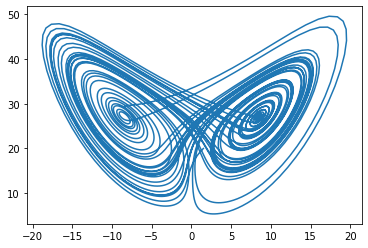

In [126]:
plt.figure()
plt.plot(lorenz_test.xvar_series[0,:], lorenz_test.xvar_series[2,:], '-')
plt.show()

## Reference simulation
Run and plot a reference simulation. This simulation will serve as "truth" from which observations will extracted and assimilated. The graphs display the time evolution of $x$, $y$, $z$, respectively.

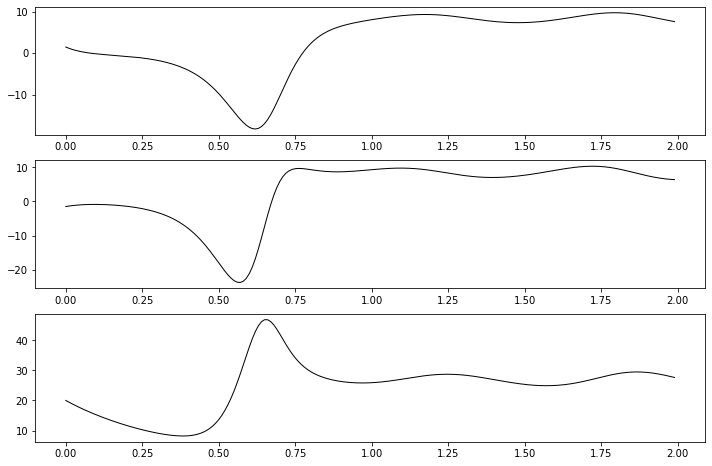

In [127]:
ntime = 200
lorenz_ref = Model()
lorenz_ref.forward(xtrue, ntime)
lorenz_ref.plot()
true_state = lorenz_ref.xvar_series
true_time = lorenz_ref.time_series

## Lorenz model with inaccurate initial condition
We define a "wrong" initial state:

In [128]:
wrong_state = onp.array([5., -4., 15.])

And we examine the consequences of initializing the model with this wrong state rather than the "true" one. On the graph, the reference simulation is in black, the one with the wrong initial condition is in red.

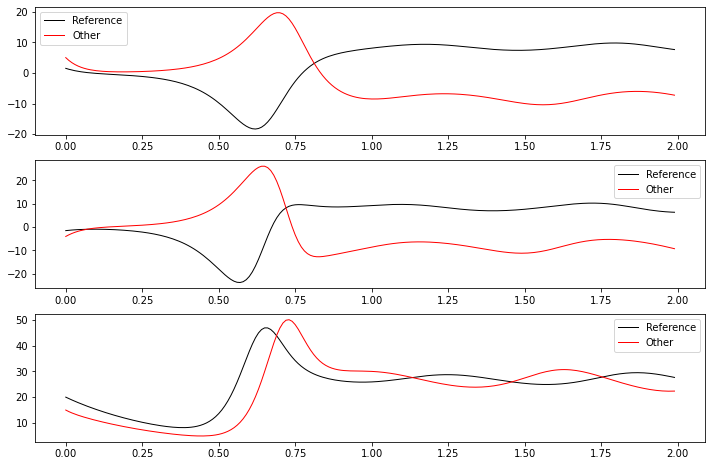

In [129]:
lorenz_test1 = Model()
lorenz_test1.forward(wrong_state, ntime)
plt.figure(figsize=(12,8))
for ix in range(3):
    pnum = 311+ix
    plt.subplot(pnum)
    plt.plot(true_time,true_state[ix,:],'black',linewidth=1.,label='Reference')
    plt.plot(lorenz_test1.time_series,lorenz_test1.xvar_series[ix,:],'red',linewidth=1.,label='Other')
    plt.legend()
plt.show()


# Data assimilation
We now turn to data assimilation. We assimilate observations extracted from the reference simulation above. Below a few basic definitions.

In [131]:
## Type and timing of observations
nvarobs = [0, 2]            ## observed variables
nobs = len(nvarobs)
assim_steps = onp.arange(0,10,2)   ## assimilation steps
assim_windows = 10            ## Length of assimilation window (number of steps)

## Observation operator
hobs = np.zeros((nobs,3))
j=0
for i in range(nobs):
    hobs = hobs.at[j,nvarobs[i]].set(1)
    j += 1

## Obs and cov matrix
yobs = hobs@true_state[:,assim_steps]
noisestd = 0.1
Robsm1 = np.eye(nobs)/(noisestd**2)
### Perturbation of observations to simulate observation errors
noise = onp.random.randn(np.size(yobs)).reshape(np.shape(yobs))
yobs = yobs + noise*noisestd

## Background
xbkgd = np.array([-3., 1., 15.])
xstd = 4
Bm1 = np.eye(3)/(xstd**2)

## Cost function and gradient

The cost function writes:
$$ J(x) = (x-x^b)^T B^{-1} (x-x^b) + \sum_{i=1}^N \left( y_i-\mathcal{H}_i(\mathcal{M}_{0-i}(x)\right)^T R_i^{-1}\left(y_i-\mathcal{H}_i(\mathcal{M}_{0-i}(x))\right) $$

and the gradient:
$$ \nabla J(x) = -B^{-1} (x-x^b) - \sum_{i=1}^N M_{0-i}^T H_i^T R_i^{-1} \left( y_i-\mathcal{H}_i(\mathcal{M}_{0-i}(x))\right) $$

Notations are as follows: $\mathcal{H}_i$ is the observation operator at time $i$; $\mathcal{M}_{0-i}$ is the model propagating $x$ from time 0 to time $i$. $H_i$ and $M_{0-i}$ refer to the respective tangent linear operators. The transposed matrices are the adjoint operators.

The gradient is computed recursively, backward in time, using the adjoint operators. The adjoint variable is initialized with $\lambda_N = H_N^T R_N^{-1} \left( y_N-\mathcal{H}_N(\mathcal{M}_{0-N}(x))\right)$. It is back-propagated using the adjoint model from $N$ to $N-1$, $M_{(N-1)-N}^T$; then, 

$ H_{N-1}^T R_{N-1}^{-1} \left( y_{N-1}-\mathcal{H}_{N-1}(\mathcal{M}_{0-{N-1}}(x))\right)$
is added; and so on and so forth until $\lambda_0$. The gradient is then $-B^{-1} (x-x^b) - \lambda_0$.

In [132]:
def CostFunction(x_in):
    # Jb
    xx = xbkgd - x_in   # wrong_state is my background
    Jb = 0.5*xx@(Bm1@xx)
    # Jo
    Jo = 0
    m = Model()
    m.forward(x_in, assim_windows)
    iobs = 0
    for i in assim_steps:
        innov = yobs[:,iobs] - hobs@m.xvar_series[:,i]
        Jo += 0.5*innov.T @ (Robsm1@innov)
        iobs += 1
    return Jb+Jo

In [133]:
CostGrad = grad(CostFunction)

## Gradient test

Works fine with a reasonably short assimilation window.

In [134]:
xr = lorenz_ref.xvar
print('xr:',xr)
dxr = np.array([-5.0,3,4])

xr: [ 7.511121  6.336802 27.38643 ]


In [152]:
for alpha in [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]:
    t1 = ( CostFunction(xr+alpha*dxr)-CostFunction(xr) ) /alpha
    t2 = CostGrad(xr)@dxr
    eps = np.abs(t1-t2)/np.abs(t2)
    print(eps)
    print((t1,t2))

0.09167768
(DeviceArray(5842.383, dtype=float32), DeviceArray(5351.747, dtype=float32))
0.00919877
(DeviceArray(5400.9766, dtype=float32), DeviceArray(5351.747, dtype=float32))
0.0010602736
(DeviceArray(5357.4214, dtype=float32), DeviceArray(5351.747, dtype=float32))
0.018282034
(DeviceArray(5253.9062, dtype=float32), DeviceArray(5351.747, dtype=float32))
0.051127616
(DeviceArray(5078.125, dtype=float32), DeviceArray(5351.747, dtype=float32))
0.27009818
(DeviceArray(3906.25, dtype=float32), DeviceArray(5351.747, dtype=float32))


### A test with JIT computation

In [148]:
CostFunction_jit = jit(CostFunction)
CostGrad_jit = jit(CostGrad)

In [149]:
for alpha in [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]:
    t1 = ( CostFunction_jit(xr+alpha*dxr)-CostFunction_jit(xr) ) /alpha
    t2 = CostGrad(xr)@dxr
    eps = np.abs(t1-t2)/np.abs(t2)
    #print(eps)
    print((t1,t2))

(DeviceArray(5842.383, dtype=float32), DeviceArray(5351.747, dtype=float32))
(DeviceArray(5401.172, dtype=float32), DeviceArray(5351.747, dtype=float32))
(DeviceArray(5357.4214, dtype=float32), DeviceArray(5351.747, dtype=float32))
(DeviceArray(5253.9062, dtype=float32), DeviceArray(5351.747, dtype=float32))
(DeviceArray(5468.75, dtype=float32), DeviceArray(5351.747, dtype=float32))
(DeviceArray(0., dtype=float32), DeviceArray(5351.747, dtype=float32))


### Minimisation of cost function, method 1

The minimization is performed using the scipy package `optimize` now included in JAX. Only the BFGS is implemented so far. The differences I found with the original scipy version are:

* the `jac` option to provide the function gradient has vanished. The gradient computation is performed by JAX.
* The results are in a tuple, not a dictionary. The optimization result is `res[0]`

<https://jax.readthedocs.io/en/latest/_autosummary/jax.scipy.optimize.minimize.html>

In [150]:
Xopt = xbkgd
res = so.minimize(CostFunction_jit, Xopt,
                   method='BFGS',
                   options={'maxiter': 30})

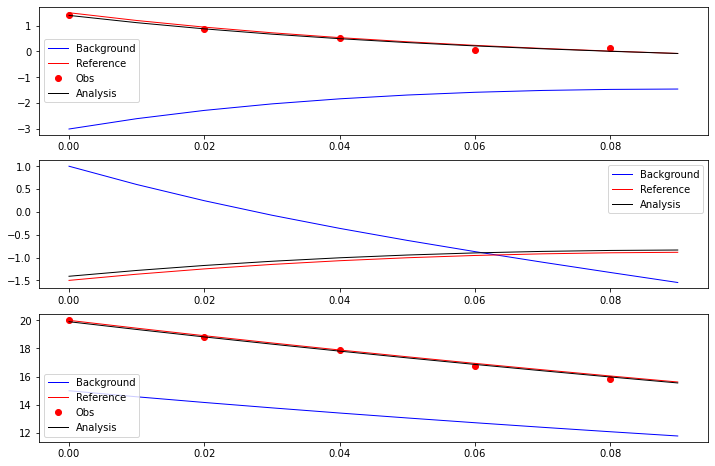

In [151]:
bkgd = Model()
bkgd.forward(xbkgd, assim_windows)
ana = Model()
ana.forward(res[0], assim_windows)
plt.figure(figsize=(12,8))
for ix in range(3):
    pnum = 311+ix
    plt.subplot(pnum)
    plt.plot(bkgd.time_series[:assim_windows], bkgd.xvar_series[ix,:assim_windows],'blue',linewidth=1.,label='Background')
    plt.plot(true_time[:assim_windows],true_state[ix,:assim_windows],'red',linewidth=1.,label='Reference')
    if ix in nvarobs:
        plt.plot(true_time[assim_steps], yobs[nvarobs.index(ix),:], 'ro', label='Obs')
    plt.plot(ana.time_series[:assim_windows], ana.xvar_series[ix,:assim_windows],'black',linewidth=1.,label='Analysis')
    plt.legend()
plt.show()

In [138]:
res[0], xtrue

(DeviceArray([ 1.3965333, -1.4098214, 19.90253  ], dtype=float32),
 DeviceArray([ 1.5, -1.5, 20. ], dtype=float32))

In [141]:
res

OptimizeResults(x=DeviceArray([ 1.3965333, -1.4098214, 19.90253  ], dtype=float32), success=DeviceArray(False, dtype=bool), status=DeviceArray(3, dtype=int32, weak_type=True), fun=DeviceArray(6.290884, dtype=float32), jac=DeviceArray([-4.9054623e-05, -5.4538250e-06, -3.5643578e-04], dtype=float32), hess_inv=DeviceArray([[ 0.00716903, -0.01031239,  0.00044761],
             [-0.01031239,  0.02846932, -0.00089785],
             [ 0.00044761, -0.00089785,  0.00246767]], dtype=float32), nfev=DeviceArray(46, dtype=int32, weak_type=True), njev=DeviceArray(46, dtype=int32, weak_type=True), nit=DeviceArray(12, dtype=int32, weak_type=True))

### Minimization of cost function, method 2 (a poor one)

Below a basic gradient descent is implemented using the cost function gradient derived with JAX. The only interest is to exhibit how simple it is to compute the gradient with JAX. The convergence is slow.

In [142]:
Xopt = xbkgd
rate = 0.001

## To control convergence and iterations
Xopt_b = np.zeros_like(Xopt)
resid = np.sum((Xopt-Xopt_b)**2)
epsilon = 1e-9
iteration, itermax = 0, 1000

while resid > epsilon:
    Xopt_b = Xopt
    grads = CostGrad(Xopt)
    Xopt = Xopt - rate * grads
    ## Convergence and iterations
    iteration +=1
    resid = np.sum((Xopt-Xopt_b)**2)
    if iteration > itermax:
        break
print('Iteration {}'.format(iteration))

Iteration 264


In [143]:
Xopt, resid

(DeviceArray([ 1.3961651, -1.4089096, 19.902496 ], dtype=float32),
 DeviceArray(9.687255e-10, dtype=float32))

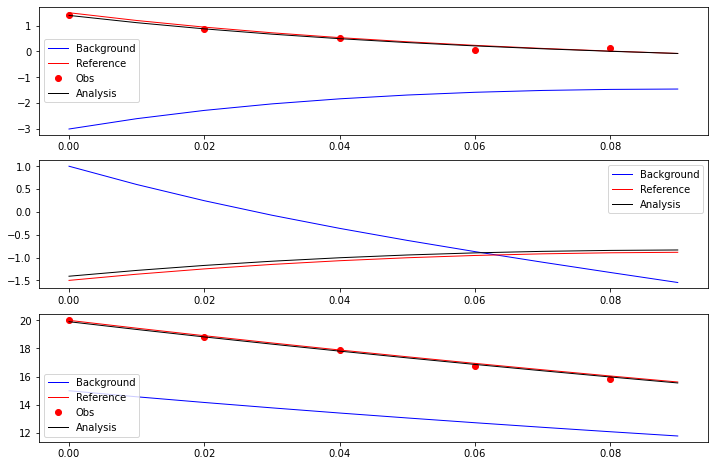

In [144]:
bkgd = Model()
bkgd.forward(xbkgd, assim_windows)
ana = Model()
ana.forward(Xopt, assim_windows)
plt.figure(figsize=(12,8))
for ix in range(3):
    pnum = 311+ix
    plt.subplot(pnum)
    plt.plot(bkgd.time_series[:assim_windows], bkgd.xvar_series[ix,:assim_windows],'blue',linewidth=1.,label='Background')
    plt.plot(true_time[:assim_windows],true_state[ix,:assim_windows],'red',linewidth=1.,label='Reference')
    if ix in nvarobs:
        plt.plot(true_time[assim_steps], yobs[nvarobs.index(ix),:], 'ro', label='Obs')
    plt.plot(ana.time_series[:assim_windows], ana.xvar_series[ix,:assim_windows],'black',linewidth=1.,label='Analysis')
    plt.legend()
plt.show()